In [44]:
from sklearn.datasets import fetch_openml
import pandas as pd
import torch
from torch.utils.data import Dataset
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

## 读取波斯顿房价数据：
    CRIM: 城镇人均犯罪率
    ZN: 住宅用地所占比例
    INDUS: 城镇中非住宅用地所占比例
    CHAS: 虚拟变量，用于回归分析
    RM: 每栋住宅的房间数
    AGE: 1940年以前建成的自住单位比例
    DIS: 距离5个波士顿就业中心的加权距离
    RAD: 距高速公路便利指数
    TAX: 每一万美元的不动产税率
    PRTATIO: 城镇中的教师学生比例
    B: 城镇中黑人比例
    LSTAT: 地区中有多少房东属于低收入人群
    
    标签：MEDV: 自住房屋房价中位数
    
其中['CHAS', 'RAD']为字符串且所有样本取值一样，所以将这两列删除。下面展示的是画图版本，抽取其中一列特征和标签作为样本进行训练，最后画图。如果需要将所有特征放进来进行训练，将下面两行注释的代码恢复，然后注释X=X['RM']，将w修改为w = torch.normal(0, 0.01, size=(11, 1), requires_grad=True)，然后正常运行其他代码即可

In [45]:
boston = fetch_openml('boston', version=1)
X = boston.data
y = boston.target

# scaler = StandardScaler()
# X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)
X=pd.DataFrame(X)
X.drop(['CHAS', 'RAD'], axis=1, inplace=True)
X=X['RM']
X=torch.tensor(X.values.tolist())
X = X.unsqueeze(1)
y=pd.DataFrame(y)
y=torch.tensor(y.values.tolist())


class CustomDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        x = self.data[index]
        y = self.labels[index]
        return x, y

train_data=CustomDataset(X,y)
train_iter=torch.utils.data.DataLoader(train_data, batch_size=16, shuffle=True)


In [46]:
w = torch.normal(0, 0.01, size=(1, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)

In [47]:

#定义模型
def model(X,w,b):
    return torch.matmul(X,w)+b
#定义loss
def loss(y,y_hat):
    return (y-y_hat)**2/2
#定义优化器
def youhua(params,lr,batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()
            
# 定义的 backward 函数
def custom_backward(loss, params):
    # 清除之前计算的梯度
    for param in params:
        param.grad = torch.zeros_like(param)
    # 计算损失对每个参数的梯度
    loss_grad = torch.autograd.grad(loss, params, create_graph=True)
    # 将计算得到的梯度应用到参数上
    for param, grad in zip(params, loss_grad):
        param.grad = grad

In [59]:
#选取超参数
lr = 0.03
num_epochs = 4

y_3=[]
#训练
for x in range(num_epochs):
    for data,label in train_iter:
        y_hat=model(data,w,b)
        l=loss(label,y_hat)#损失计算
        l=l.sum()
        custom_backward(l,[w,b])#梯度计算
        youhua([w,b],lr,16)#优化梯度
    with torch.no_grad():#打印损失
        y_2 = model(X, w, b)
        y_3=y_2
        train_l = loss(y, y_2)
        print(f'epoch {x + 1}, loss {float(train_l.mean()):f}')
print(w,'\n',b)

epoch 1, loss 25.095375
epoch 2, loss 25.218496
epoch 3, loss 26.416515
epoch 4, loss 24.962509
tensor([[5.5290]], requires_grad=True) 
 tensor([-12.3993], requires_grad=True)


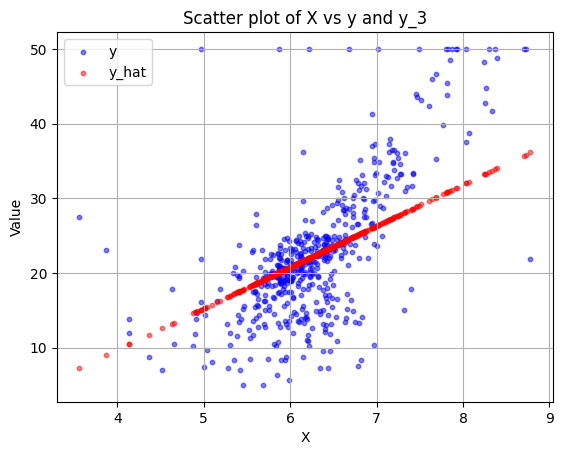

In [60]:
X_np = X.numpy()
y_np = y.numpy()
y_3_np=y_3.numpy()

# 绘制散点图
plt.scatter(X_np, y_np, alpha=0.5, c='blue', label='y', s=10)  # 设置点的大小为 20
plt.scatter(X_np, y_3_np, alpha=0.5, c='red', label='y_hat', s=10)  # 设置点的大小为 20

plt.title('Scatter plot of X vs y and y_3')
plt.xlabel('X')
plt.ylabel('Value')
plt.grid(True)
plt.legend()
plt.show()